# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico I : Análisis de features de audio

**Consideraciones:**
- Se evalúa el estilo y prolijidad del código.
- Se permite hacer trabajo extra, siempre y cuando las actividades básicas estén resueltas.

### Librerías

In [ ]:
!pip3 install spotipy
!pip3 install pandas
!pip3 install seaborn

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso al API

In [ ]:
import pandas as pd
import numpy as np
import spotipy
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from spotipy.oauth2 import SpotifyClientCredentials

client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#-------------Calculos Generales----------------------------

def loadArtistGenre(artist_tracks_dict, artists_id_list):
    ''' 
    '''    
    artists = sp.artists(artists_id_list)
    for artist in artists['artists']:
        artist_tracks_dict['artist_id'].append(artist['id'])
        artist_tracks_dict['artist_name'].append(artist['name'])
        genre = None
        if artist['genres']:
            genre = artist['genres'][0]
        artist_tracks_dict['genre'].append(genre)   
    return pd.DataFrame(artist_tracks_dict)

    
def loadTrackFeatures(features_track, tracks_id):
    
    features = sp.audio_features(tracks_id)
    for feature in features:
        for column_name in features_track.keys():           
            features_track.get(column_name).append(feature.get(column_name))
    return pd.DataFrame(features_track)
            

def loadTracksFromPlayListItems(tracks_dict, playlist_items):
    
    for item in playlist_items:
        track = item.get('track')
        for column_name in tracks_dict.keys():            
            if column_name == 'artist_id':
                artist = track.get('album').get('artists')[0];
                tracks_dict['artist_id'].append(artist.get('id'))
            else: 
                tracks_dict.get(column_name).append(track.get(column_name))
    return pd.DataFrame(playlist_items)

def getPlaylistDataFrame(playlist_id):
    offset = 0
    total_tracks = None
    artist_tracks_dict = {'artist_id':[],'artist_name': [], 'genre':[]}
    features_tracks_dict = {'id': [], 'key':[], 'mode':[], 'time_signature':[], 'tempo':[], 
                       'acousticness':[], 'danceability':[], 'energy':[], 'instrumentalness':[], 'valence':[] }
    tracks_dict = {'id': [],'name': [], 'artist_id':[] } 

    while True:        
        tracks = sp.playlist_tracks(playlist_id, offset=offset, additional_types=('track',))  
        playlist_items = tracks['items']
        limit = tracks.get('limit')

        loadTracksFromPlayListItems(tracks_dict, playlist_items)
        loadArtistGenre(artist_tracks_dict, dict.fromkeys(tracks_dict['artist_id'][offset:offset + limit]))      
        loadTrackFeatures(features_tracks_dict, tracks_id=tracks_dict.get('id')[offset:offset + limit])


        total_tracks = tracks.get('total') if (total_tracks is None) else total_tracks
        offset = tracks.get('offset') + limit

        if offset > total_tracks:
            break
    df_tracks = pd.DataFrame(tracks_dict)
    df_features_tracks = pd.DataFrame(features_tracks_dict)
    df_artists_tracks = pd.DataFrame(artist_tracks_dict)
    df_artists_tracks.drop_duplicates(keep = 'first', inplace=True)
    data_set = pd.merge(df_tracks, df_artists_tracks, how='inner', on='artist_id')
    data_set = pd.merge(data_set, df_features_tracks, how='inner', on='id')
    return data_set    

def display_markdown(*args, **kwargs):
    return display(Markdown(*args, **kwargs))


In [ ]:
mentoria_playlist_id = '2IuD0qZb14cji5y52crdsO'
df_mentoria = getPlaylistDataFrame(mentoria_playlist_id)
df_mentoria

,id,name,artist_id,artist_name,genre,key,mode,time_signature,tempo,acousticness,danceability,energy,instrumentalness,valence
0,7j9DYPyCuvSAtPcevpAkzb,Desafío,4SQdUpG4f7UbkJG3cJ2Iyj,Arca,art pop,1,0,5,161.092,0.4860,0.161,0.482,0.409000,0.0926
1,1cwTMSQeMaA9fVKEF1iWeD,Anoche,4SQdUpG4f7UbkJG3cJ2Iyj,Arca,art pop,10,0,5,80.793,0.5700,0.230,0.434,0.000000,0.0834
2,0aL27vskbMpwsMGUkHm3Zf,Sin Rumbo,4SQdUpG4f7UbkJG3cJ2Iyj,Arca,art pop,9,1,3,124.835,0.8740,0.289,0.280,0.004430,0.0391
3,3klBAH0wi8hR1kvRmiHRvw,Piel,4SQdUpG4f7UbkJG3cJ2Iyj,Arca,art pop,4,0,3,67.905,0.5910,0.148,0.167,0.742000,0.0377
4,2kfSFdq2h0xLXq01em1zc7,La Gata Bajo la Lluvia,2uyweLa0mvPZH6eRzDddeB,Rocío Dúrcal,bolero,7,1,4,88.140,0.7230,0.499,0.648,0.000000,0.4640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,5fRgvfgF4TM947Gi6qOlcF,Bastará,2ST5XwWB4uXGKk2NXP8DUI,Los Cafres,argentine reggae,8,1,4,84.965,0.2050,0.734,0.604,0.000003,0.9270
591,3KDClBkoakbdF0pSdF2PP7,Descontrolado,6UYYp6Xo2NHP7AxNnR0rn4,Jóvenes Pordioseros,argentine rock,9,1,4,140.037,0.0113,0.569,0.809,0.000000,0.7720
592,6eKYlDXNbMTKYyt7APb8kn,Un Mundo Mejor,4nrP6H78NuKzQr9bQxAFVk,Riddim,argentine reggae,4,0,4,92.012,0.1470,0.746,0.649,0.000612,0.8510
593,71T6mf9jsYoLByrbkeZJQA,Perdiste,2IucHN96T0BZ3e4mXe9AgP,AHYRE,None,2,0,4,84.900,0.0607,0.552,0.799,0.000000,0.9440


### 1) Plantear una pregunta que quieran responder con estos datos

Las preguntas pueden ser por ejemplo: 
- ¿Por qué este artista destaca dentro de su género?
- ¿Por qué no lo hace?
- ¿Por qué un género musical es más escuchado que otro?

Sin embargo, pueden usar cualquier afirmación que hayan leído en internet y que se pueda responder con los datos de este trabajo para validarla o rechazarla.

---
### **Pregunta**
#### **¿Cuales son los 5 generos más destacados? ¿Qué hace que estos generos destaquen sobre los demás?**
---

### 2) Obtener datos para responder la pregunta

Para esto hay que hacer pedidos a la API para obtener una lista de canciones de sus artistas, de las cuáles se obtienen sus features de audio como en este [ejemplo](https://developer.spotify.com/console/get-audio-features-track/?id=17VP4tofJ3evJbtY8Tk1Qi) de la versión web de la API. Una vez obtenidos los datos, seleccionar un subconjunto de 5 o 6 features de audio y agrupar los datos en un [DataFrame de pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

**Recomendación** : Usar un dataframe para su artista y otro para la competencia si es que eligierone esa opción, les va a ahorrar tiempo.

**Aclaración** : Si plantearon una pregunta que no requiera los datos de la consigna, obtengan esos datos.

---
### Respuesta a la pregunta pregunta

#### ¿Cuales son los 5 generos más destacados? ¿Qué hace que estos generos destaquen sobre los demás?
##### Los 5 generos más destacados son **Cuarteto, Argentine Indie, Argentine Rock, Argentine Alternative Rock y Bolero**. Mediante el análisis se observa que estos géneros presentan ritmos alegres, más positivos con los cuales se pueda bailar. Es por eso que el género mas alegre como lo es el cuarteto encabece este ranking.
#### Analisis:

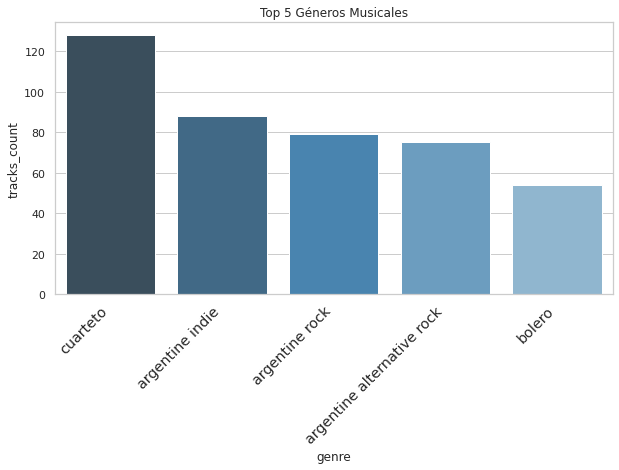

,genre,tracks_count,key_mean,mode_mean,time_signature_mean,tempo_mean,acousticness_mean,danceability_mean,enegy_mean,instrumetalsness_mean,valence_mean
0,cuarteto,128,4.976562,0.421875,4.000000,140.949859,0.238405,0.557945,0.777422,9.577344e-07,0.668492
1,argentine indie,88,4.590909,0.579545,3.875000,122.161432,0.198366,0.618045,0.612841,6.573536e-02,0.503064
2,argentine rock,79,5.265823,0.632911,3.936709,123.203316,0.257901,0.587873,0.683190,2.818185e-02,0.622841
3,argentine alternative rock,75,5.333333,0.680000,4.000000,122.652907,0.199684,0.644587,0.636027,6.202383e-02,0.538473
4,bolero,54,4.407407,0.722222,3.851852,125.141519,0.391730,0.513111,0.612667,2.029017e-04,0.498739


In [ ]:
agg_dict={'id':['count'], 
          'key':['mean'], 
          'mode':['mean'], 
          'time_signature':['mean'], 
          'tempo':['mean'], 
          'acousticness':['mean'], 
          'danceability':['mean'], 
          'energy':['mean'], 
          'instrumentalness':['mean'],
          'valence':['mean'] }
df_genre_group = df_mentoria.groupby(by=['genre']).agg(agg_dict)
df_genre_group.columns = ['tracks_count', 'key_mean', 'mode_mean', 'time_signature_mean', 'tempo_mean','acousticness_mean', 'danceability_mean', 'enegy_mean', 'instrumetalsness_mean','valence_mean']
df_genre_top5_group = df_genre_group.sort_values(by='tracks_count', ascending=False, na_position='first')[:5]
df_genre_top5_group.reset_index(inplace=True)

plt.figure(figsize=(10,5))
plt.title('Top 5 Géneros Musicales')
seaborn.set(style='whitegrid')
seaborn.barplot(x='genre', y='tracks_count', data = df_genre_top5_group, palette='Blues_d' )
plt.xticks( rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large' 
           )
plt.show()
df_genre_top5_group



No handles with labels found to put in legend.


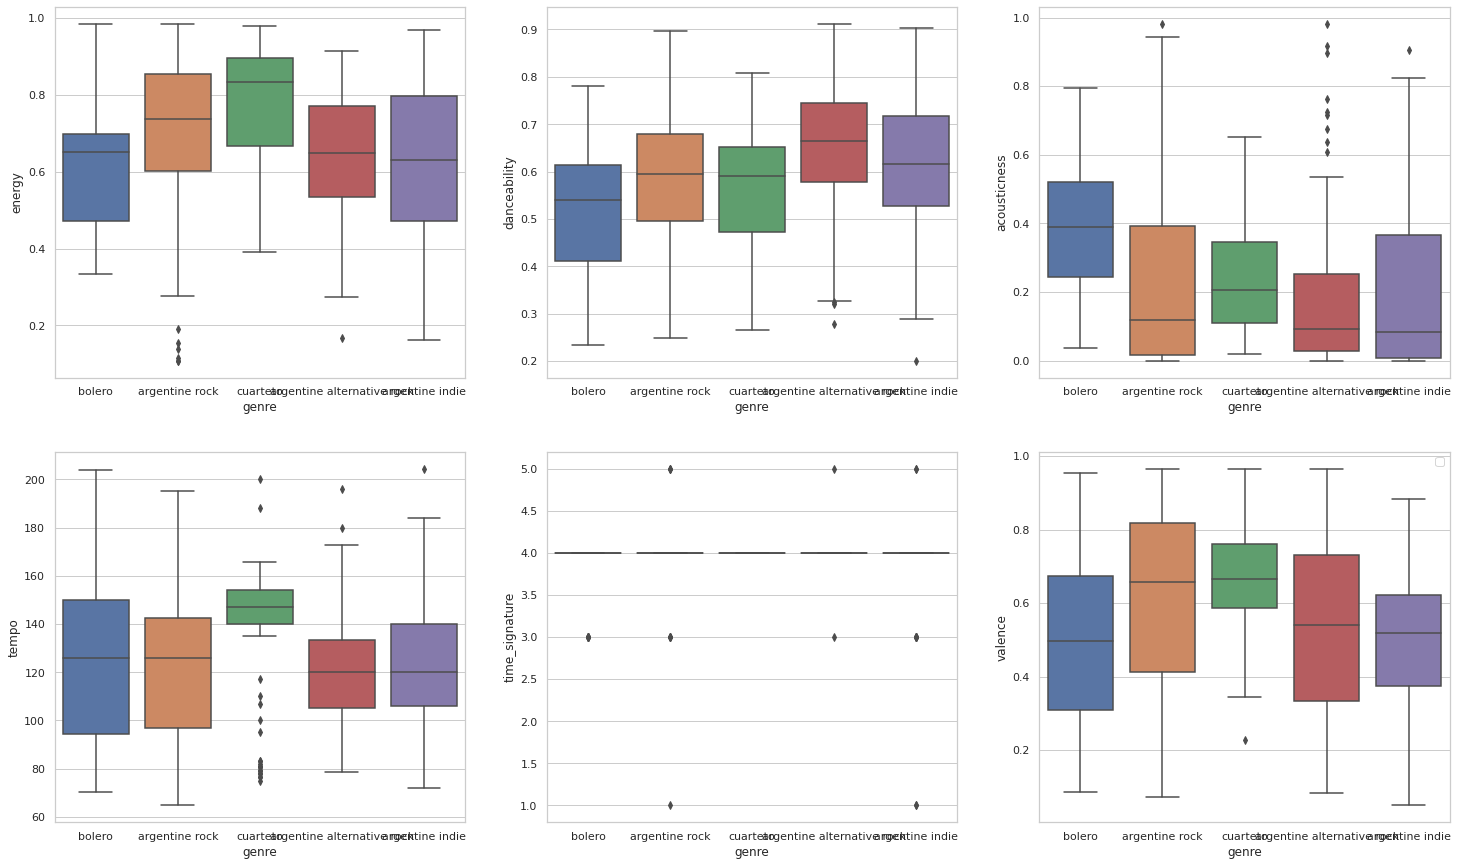

In [ ]:
df_top5_genre = df_mentoria.loc[df_mentoria.genre.isin(['cuarteto', 'argentine indie', 'argentine rock', 'argentine alternative rock', 'bolero'])]
figure, axes = plt.subplots(2,3, figsize=(25,15))
seaborn.boxplot(data=df_top5_genre, x='genre', y='energy',ax=axes[0,0])
seaborn.boxplot(data=df_top5_genre, x='genre', y='danceability',ax=axes[0,1])
seaborn.boxplot(data=df_top5_genre, x='genre', y='acousticness',ax=axes[0,2])
seaborn.boxplot(data=df_top5_genre, x='genre', y='tempo',ax=axes[1,0])
seaborn.boxplot(data=df_top5_genre, x='genre', y='time_signature',ax=axes[1,1])
seaborn.boxplot(data=df_top5_genre, x='genre', y='valence',ax=axes[1,2])
plt.legend()
plt.show()



### Conclusión  del análisis del análisis de datos
* Los 5 géneros tiene en común que posee una media mayor a 6 en relación al parametro **energy**, lo que significa que se prefiere escuchar temas más intensos, enérgicos.
* Los 4 primeros géneros tiene una media mayor a 6, lo que significa que es de preferencia los temas musicales bailables.
* Los 4 primeros géneros presenta un valor muy bajo en el parámetro **acousticness**, concluyendo que los temas acústicos no son lo más preferidos.
* A partir del parámetro **key** se detaca que lo temas presenta un tono medio de 4(mi) y 5(fa)
* Los 5 géneros presentan un media de 4 en el parámetro **time signature**, algo a destacar en relación a la estructura musical, presentan cuatro tiempos por compas. 
* La variable tempo indica la velocidad en que suena la música. Los 5 géneros presenta una media superior a 120, consideranse temas musicales rápidos.
* El género más destacado "cuarteto" presenta una media en el parámetro **valance** mayor a los demás generos. Es el tema considerado con un mayor valor de positivismo.

---


### 3) Hacer un gráfico de estilo [radar chart](https://en.wikipedia.org/wiki/Radar_chart)  comparando a su artista o banda con 'la competencia'
En esta parte tienen que hacer los gráficos tomando como parámetros las features de audio que eligieron. Pueden usar la librería que quieran para hacer los gráficos.

**Recomendaciones** : 
- Hacer ambos gráficos en una misma figura.
- Antes de graficar, obtener los valores medios o medianos para los valores de las features. 
- Chequear los rangos de valores para cada feature antes de hacer los gráficos.

**Aclaración**: pueden usar otro tipo de gráfico si lo consideran particularmente útil para resolver su pregunta.

In [ ]:
df_cuarteto = df_mentoria[df_mentoria.genre == 'cuarteto'][['artist_name','id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'valence']]
agg_dict={'id':['count'], 
          'acousticness':['mean'], 
          'danceability':['mean'], 
          'energy':['mean'], 
          'instrumentalness':['mean'], 
          'valence':['mean'] }

df_cuarteto_artists = df_cuarteto.groupby(by=['artist_name']).agg(agg_dict)
df_cuarteto_artists = df_cuarteto_artists.reset_index()
df_cuarteto_artists.columns = ['artist','tracks','acousticness','danceability','energy','instrumentalness','valence']
df_cuarteto_artists

,genre,tracks_count,key_mean,mode_mean,time_signature_mean,tempo_mean,acousticness_mean,danceability_mean,enegy_mean,instrumetalsness_mean,valence_mean
0,cuarteto,128,4.976562,0.421875,4.000000,140.949859,0.238405,0.557945,0.777422,9.577344e-07,0.668492
1,argentine indie,88,4.590909,0.579545,3.875000,122.161432,0.198366,0.618045,0.612841,6.573536e-02,0.503064
2,argentine rock,79,5.265823,0.632911,3.936709,123.203316,0.257901,0.587873,0.683190,2.818185e-02,0.622841
3,argentine alternative rock,75,5.333333,0.680000,4.000000,122.652907,0.199684,0.644587,0.636027,6.202383e-02,0.538473
4,bolero,54,4.407407,0.722222,3.851852,125.141519,0.391730,0.513111,0.612667,2.029017e-04,0.498739


In [ ]:
r_jimenez = df_cuarteto_artists[df_cuarteto_artists.artist == 'La Mona Jimenez'].values.tolist()[0][2:]
r_barra = df_cuarteto_artists[df_cuarteto_artists.artist == 'La Barra'].values.tolist()[0][2:]
r_konga = df_cuarteto_artists[df_cuarteto_artists.artist == "La K'onga"].values.tolist()[0][2:]
r_sabroso = df_cuarteto_artists[df_cuarteto_artists.artist == 'Sabroso'].values.tolist()[0][2:]
r_ulises = df_cuarteto_artists[df_cuarteto_artists.artist == 'Ulises Bueno'].values.tolist()[0][2:]
theta = df_cuarteto_artists.columns.tolist()[2:]

fig = go.Figure()

fill = 'none'

fig.add_trace(go.Scatterpolar(
      r=r_barra,
      theta=theta,
      fill=fill,
      name='La Barra'
))
fig.add_trace(go.Scatterpolar(
      r=r_konga,
      theta=theta,
      fill=fill,
      name="La K'onga"
))
fig.add_trace(go.Scatterpolar(
      r=r_sabroso,
      theta=theta,
      fill=fill,
      name="Sabroso"
))
fig.add_trace(go.Scatterpolar(
      r=r_ulises,
      theta=theta,
      fill=fill,
      name="Ulises Bueno"
))
fig.add_trace(go.Scatterpolar(
      r=r_jimenez,
      theta=theta,
      fill=fill,
      name='La Mona Jimenez'
))

fig.update_layout(
    title='Radar Chart Artistas de Cuarteto',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1])
        ),
  showlegend=True
)
fig.show()

In [ ]:
df_genre_top5 = df_genre_top5_group[['genre', 'acousticness_mean', 'danceability_mean', 'enegy_mean', 'instrumetalsness_mean', 'valence_mean']]
df_genre_top5.columns = ['genre', 'acousticness', 'danceability', 'enegy', 'instrumetalsness', 'valence']
df_genre_top5

,genre,acousticness,danceability,enegy,instrumetalsness,valence
0,cuarteto,0.238405,0.557945,0.777422,9.577344e-07,0.668492
1,argentine indie,0.198366,0.618045,0.612841,6.573536e-02,0.503064
2,argentine rock,0.257901,0.587873,0.683190,2.818185e-02,0.622841
3,argentine alternative rock,0.199684,0.644587,0.636027,6.202383e-02,0.538473
4,bolero,0.391730,0.513111,0.612667,2.029017e-04,0.498739


In [ ]:

r_cuarteto = df_genre_top5[df_genre_top5.genre == 'cuarteto'].values.tolist()[0][2:]
r_argentine_indie = df_genre_top5[df_genre_top5.genre == 'argentine indie'].values.tolist()[0][2:]
r_argentine_rock = df_genre_top5[df_genre_top5.genre == "argentine rock"].values.tolist()[0][2:]
r_alternative_rock = df_genre_top5[df_genre_top5.genre == 'argentine alternative rock'].values.tolist()[0][2:]
r_bolero = df_genre_top5[df_genre_top5.genre == 'bolero'].values.tolist()[0][2:]
theta = df_genre_top5.columns.tolist()[2:]

fig = go.Figure()

fill = 'none'

fig.add_trace(go.Scatterpolar(
      r=r_cuarteto,
      theta=theta,
      fill=fill,
      name='Cuarteto'
))
fig.add_trace(go.Scatterpolar(
      r=r_argentine_indie,
      theta=theta,
      fill=fill,
      name="Argentine Indie"
))
fig.add_trace(go.Scatterpolar(
      r=r_argentine_rock,
      theta=theta,
      fill=fill,
      name="Argentine Rock"
))
fig.add_trace(go.Scatterpolar(
      r=r_alternative_rock,
      theta=theta,
      fill=fill,
      name="Argentine Alternative Rock"
))
fig.add_trace(go.Scatterpolar(
      r=r_bolero,
      theta=theta,
      fill=fill,
      name='Bolero'
))

fig.update_layout(
    title='Radar Chart Géneros',
    polar=dict(        
        radialaxis=dict(
            visible=True,
            range=[0, 1])
        ),
  showlegend=True
)
fig.show()

In [ ]:
df_genre_top5_group

,genre,tracks_count,key_mean,mode_mean,time_signature_mean,tempo_mean,acousticness_mean,danceability_mean,enegy_mean,instrumetalsness_mean,valence_mean
0,cuarteto,128,4.976562,0.421875,4.000000,140.949859,0.238405,0.557945,0.777422,9.577344e-07,0.668492
1,argentine indie,88,4.590909,0.579545,3.875000,122.161432,0.198366,0.618045,0.612841,6.573536e-02,0.503064
2,argentine rock,79,5.265823,0.632911,3.936709,123.203316,0.257901,0.587873,0.683190,2.818185e-02,0.622841
3,argentine alternative rock,75,5.333333,0.680000,4.000000,122.652907,0.199684,0.644587,0.636027,6.202383e-02,0.538473
4,bolero,54,4.407407,0.722222,3.851852,125.141519,0.391730,0.513111,0.612667,2.029017e-04,0.498739


### 4) Escribir un informe

Este informe tiene que describir qué datos que obtuvieron, el volumen de estos (# de canciones del artista, # de canciones de la competencia, etc), una explicación de cómo estos se relacionan con la pregunta planteada, cómo ayudan a responderla y los resultados que obtuvieron. Usar la celda de abajo con formato markdown.


---
Para poder realizar este trabajo se uso un set de datos con 595 temas musicales, de los cuales un total de 120 corresponden al género mas destacado. Con esta información se planteo responder la pregunta de cual es el género mas destacado en la playlist y cuales son los parametros que llevan a este género encabezar el ranking. Se definió trabajar sobre un ranking 5 generos.
Luesgo del analisis de datos se establecion que el 71% de los temas se centran en los primero 5 géneros mas destacado. Los cuales se listan a continuación:
* **Cuarteto** con 128 temas musicales.
* **Argentine indie** con 88 temas musicales.
* **Argentine rock** con 79 temas musicales.
* **Argentine alternative rock** con 75 temas musicales.
* **Bolero** con 54 temas musicales.
Para poder responder nuestra pregunta y entender porque estos géneros son los más destacados dentro de la playlist se decidio recolectar información de las siguientes variables:
* **artist_name (Nombre del artista)**: a fines prácticos solo se selecciona un solo artista, en caso de que el tema musical sea interpretado por más de un artista.
* **genre (Género del artista)**: en caso que el artiste interprete varios generos, solo se seleccionó un genero de la lista.
* **Key** : denota la tonalidad en la que suena el tema musical. Sus valores corresopnden a [pitch class](https://en.wikipedia.org/wiki/Pitch_class)
* **mode**: indica el modo musical (mayor o menor) en el que suena el tema musical.
* **time_signature**: nos indica cuantos tiempos por compas tiene el tema. Valor entero.
* **tempo**: corresponde a la velocidad del tema musical, un valor mayor a 110 es considerado un tema alegre, rápido.
* **acousticness**: valores entre 0 y 1, un valor 1 para el tema mas acústico.
* **danceability**: define que tan acorde es el tema para bailar. Presenta valores entre 0 y 1, el valor cero para el menor apto para bailar.
* **energy**: define que tan intenso/enérgico es el tema. Los valores rondan entre 0 y 1, valor 0 para el menos intenso.
* **instrumentalness**: identifica que tan instrumental es el tema. Con valor cercano a 1 mayor será la probabilidad que el tema no tenga contenido vocal.
* **valence**: esta variable describe la positividad del tema musical. Un valor cercano a 1 definiria al tema como alegre y positivo.
El análisis de esas variables nos ayudaran a entender cuales son los parametros que caracterizan que un género musical destaque sobre los demás y cuales son la preferencia actuales de los usuarios de la playlist.
Como se comento al principio los 5 géneros destacados son el **cuarteto**, **Argentine indie**, **Argentine Rock**, **Argentina alternative rock** y **bolero**.
Se identifico mediante un radar **Radar Chart Géneros** que los valores energy, danceability y los box plots que ambos generos tiene valores promedio similares y altos. De análisis echo podemos mostrar la siguiente información a modo conclusión:
  * Los 5 géneros tiene en común que posee una media mayor a 6 en relación al parametro **energy**, lo que significa que se prefiere escuchar temas más intensos, enérgicos.
  * Los 4 primeros géneros tiene una media mayor a 6, lo que significa que es de preferencia los temas musicales bailables.
  * Los 4 primeros géneros presenta un valor muy bajo en el parámetro **acousticness**, concluyendo que los temas acústicos no son lo más preferidos.
  * A partir del parámetro **key** se detaca que lo temas presenta un tono medio de 4(mi) y 5(fa)
  * Los 5 géneros presentan un media de 4 en el parámetro **time signature**, algo a destacar en relación a la estructura musical, presentan cuatro tiempos por compas. 
  * La variable tempo indica la velocidad en que suena la música. Los 5 géneros presenta una media superior a 120, consideranse temas musicales rápidos.
  * El género más destacado "cuarteto" presenta una media en el parámetro **valance** mayor a los demás generos. Es el tema considerado con un mayor valor de positivismo.

También podemos decir que estos generos presentans temas musicales rapidos, caracteristica de los temas musicales considerados alegres.
Mediante este análisis podemos se llego a la conclusión de que los temas más destacatos son aquellas que pertenecen a un género musical alegre, positivo que permita a la gente que la escucha bailar.

---